In [1]:
import sys
sys.path.append("../../../")

from utils.misc import select_cuda_device
device = select_cuda_device()

Selected device 0, which has 10822 MB available.


In [2]:
import torch

import matplotlib.pyplot as plt

import pickle

from einops import rearrange

from hydra import initialize, compose
from hydra.utils import instantiate

from smc.images import ImageModel, M71ImageModel

In [3]:
with initialize(config_path=".", version_base=None):
    cfg = compose(config_name="config")

In [4]:
with open('data/params.pkl', 'rb') as f:
    params = pickle.load(f)

params

{'flux_alpha': 0.2095324275668239,
 'flux_lower': 0.25165176391601557,
 'flux_upper': 1804.6791992187502,
 'counts_rate': 1.9302325248718262,
 'background': 104.1486587524414,
 'adu_per_nmgy': 238.77052307128906,
 'psf_params': tensor([1.2674, 2.9369, 6.7734, 6.7684, 0.3780, 0.0586]),
 'noise_additive': 3.730366984200373e-07,
 'noise_multiplicative': 1.2142912149429321}

---

**Gaussian PSF (default in `ImageModel`):**

In [5]:
image_model = ImageModel(image_height = 25,
                         image_width = 25,
                         background = params["background"],
                         psf_stdev = 1.9273269405185427)

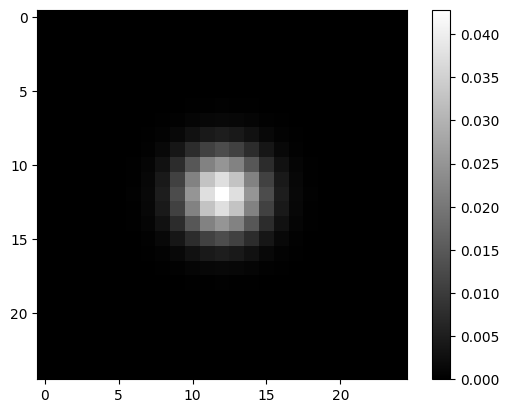

In [6]:
locs = torch.zeros([1,1,1,1,2])
locs[...,0,:] = torch.tensor([12.5, 12.5])

gaussian_psf = image_model.psf(locs).squeeze()

_ = plt.imshow(gaussian_psf, cmap = 'gray')
_ = plt.colorbar()

**SDSS PSF (rasterized):**

In [7]:
sdss = instantiate(cfg.surveys.sdss)
sdss.prepare_data()

In [8]:
sdss_psf = sdss.psf.psf_galsim[sdss.image_id(0)][2].original.image.array

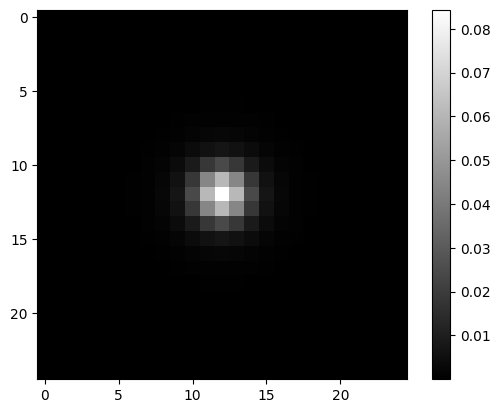

In [9]:
_ = plt.imshow(sdss_psf, cmap = 'gray')
_ = plt.colorbar()

**SDSS PSF (model-based, with a Gaussian core and a power-law wing):**

In [10]:
m71_image_model = M71ImageModel(image_height = sdss_psf.shape[0],
                                image_width = sdss_psf.shape[1],
                                background = params["background"],
                                adu_per_nmgy = params["adu_per_nmgy"],
                                psf_params = params["psf_params"],
                                noise_additive = params["noise_additive"],
                                noise_multiplicative = params["noise_multiplicative"])

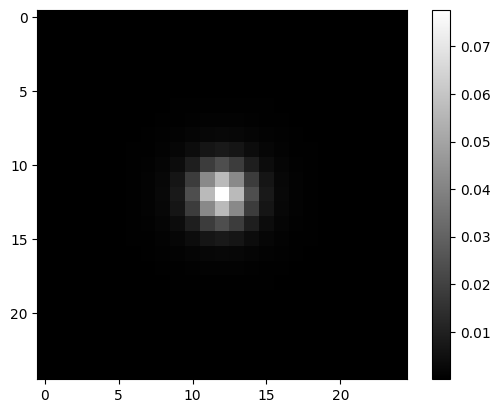

In [11]:
sdss_psf2 = m71_image_model.psf(locs).squeeze()
_ = plt.imshow(sdss_psf2, cmap = 'gray')
_ = plt.colorbar()

**Compare the two SDSS PSFs:**

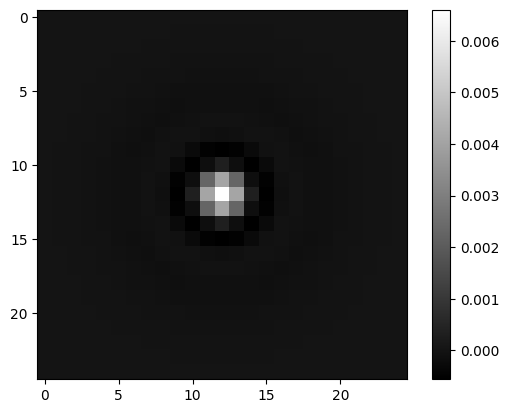

In [12]:
_ = plt.imshow(sdss_psf - sdss_psf2.numpy(), cmap = 'gray')
_ = plt.colorbar()

---

**Compare to empirical PSF from an M71 tile with one isolated source**

In [13]:
tiles = torch.load("data/tiles.pt")
counts = torch.load("data/counts_magcut.pt")
locs = torch.load("data/locs_magcut.pt")
fluxes = torch.load("data/fluxes_magcut.pt")

In [14]:
m71_image_model = M71ImageModel(image_height = tiles.shape[1], # changed from above
                                image_width = tiles.shape[2], # changed from above
                                background = params["background"],
                                adu_per_nmgy = params["adu_per_nmgy"],
                                psf_params = params["psf_params"],
                                noise_additive = params["noise_additive"],
                                noise_multiplicative = params["noise_multiplicative"])

Here's an actual tile:

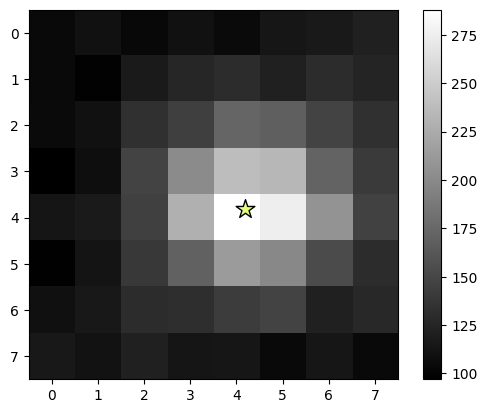

In [15]:
idx = torch.where((counts == 1) * ((locs[...,0,0] - 4).abs() < 1) * ((locs[...,0,1] - 4).abs() < 1))[0][5].item()
_ = plt.imshow(tiles[idx], cmap = 'gray')
_ = plt.colorbar()
_ = plt.scatter(locs[idx][...,:1,1] - 0.5,
                locs[idx][...,:1,0] - 0.5,
                c = fluxes[idx][...,0], marker = '*', cmap = 'Wistia', s = 200, edgecolors = 'black')

Here's a noiseless reconstruction based on our PSF model:

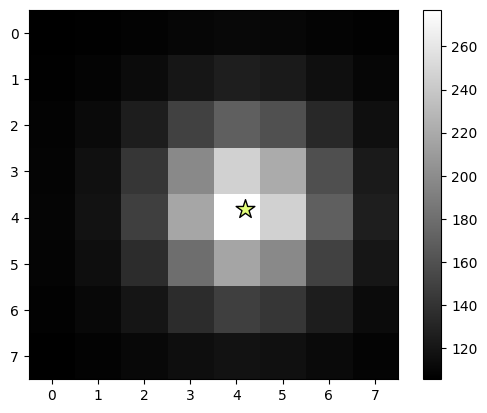

In [16]:
psf = m71_image_model.psf(rearrange(locs[idx], "d t -> 1 1 1 d t"))
rate = (
    psf
    * rearrange(
        m71_image_model.adu_per_nmgy * rearrange(fluxes[idx], "d -> 1 1 1 d"), "numH numW n d -> numH numW 1 1 n d"
    )
).sum(-1) + m71_image_model.background
rate = rate.squeeze()

_ = plt.imshow(rate, cmap = 'gray')
_ = plt.colorbar()
_ = plt.scatter(locs[idx][...,:1,1] - 0.5,
                locs[idx][...,:1,0] - 0.5,
                c = fluxes[idx][...,0], marker = '*', cmap = 'Wistia', s = 200, edgecolors = 'black')

And here's the difference between the actual tile and our noiseless reconstruction:

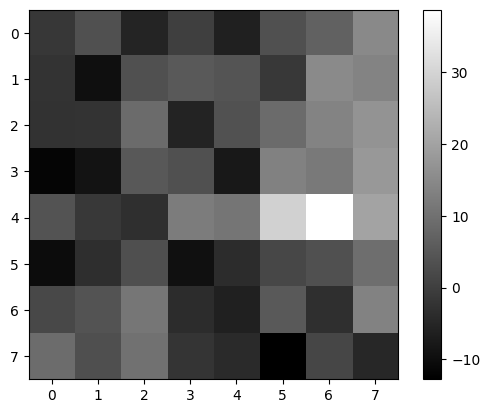

In [17]:
_ = plt.imshow(tiles[idx] - rate, cmap = 'gray')
_ = plt.colorbar()